# Proximal Policy Optimization (PPO) for VIMA

## Introduction
In this tutorial, we apply **Proximal Policy Optimization (PPO)** to the VIMA environment. PPO is a popular on-policy algorithm that balances ease of implementation, sample efficiency, and ease of tuning.

Unlike SAC (which maximizes entropy), PPO optimizes a **clipped surrogate objective** to ensure that policy updates are not too large, preventing the "catastrophic forgetting" often seen in standard Policy Gradient methods.

### Key Metrics We Will Monitor
1.  **Episode Rewards:** The primary measure of success.
2.  **Episode Length:** Efficiency (how fast does it reach the target?).
3.  **Value Loss:** How well the Critic predicts future rewards.
4.  **Policy Loss:** The surrogate objective being optimized.
5.  **Entropy:** The randomness of the agent's actions (exploration).

In [10]:
# ============================
# 1. INSTALLS & IMPORTS
# ============================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO # Using your LSTM model preference
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results

# ============================
# 2. VIMA ENVIRONMENT
# ============================
def get_lidar(agent_pos, agent_angle, objects, cfg):
    num_rays = cfg['lidar_rays']
    max_range = cfg['lidar_range']
    fov = cfg['lidar_fov']
    lidar_readings = np.full(num_rays, max_range)
    start_angle = agent_angle - fov / 2
    angle_step = fov / num_rays
    
    for i in range(num_rays):
        ray_angle = start_angle + i * angle_step
        ray_dir = np.array([math.cos(ray_angle), math.sin(ray_angle)])
        for obj in objects:
            to_obj = obj['pos'] - agent_pos
            proj = np.dot(to_obj, ray_dir)
            if 0 < proj < max_range:
                dist_line = np.linalg.norm(to_obj - proj * ray_dir)
                if dist_line < obj['radius']:
                    dist = proj - math.sqrt(obj['radius']**2 - dist_line**2)
                    if 0 < dist < lidar_readings[i]:
                        lidar_readings[i] = dist
    return lidar_readings

class VIMAEnv(gym.Env):
    def __init__(self):
        super(VIMAEnv, self).__init__()
        self.cfg = {
            'width': 800, 'height': 800,
            'agent_radius': 10, 'target_radius': 15,
            'obstacle_count': 5, 'human_count': 3,
            'lidar_rays': 36, 'lidar_range': 200, 'lidar_fov': math.pi * 2,
            'max_steps': 500
        }
        self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
        obs_dim = self.cfg['lidar_rays'] + 4 # Lidar + Target(2) + Velocity(2)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = np.array([self.cfg['width']/2, self.cfg['height']/2])
        self.agent_angle = 0.0
        self.agent_vel = np.array([0.0, 0.0])
        self.target_pos = np.random.rand(2) * [self.cfg['width'], self.cfg['height']]
        
        self.objects = []
        for _ in range(self.cfg['obstacle_count']):
            self.objects.append({'pos': np.random.rand(2) * [self.cfg['width'], self.cfg['height']], 'radius': 20})
        self.humans = []
        for _ in range(self.cfg['human_count']):
            self.humans.append({'pos': np.random.rand(2)*[800,800], 'radius': 15, 'vel': (np.random.rand(2)-0.5)*2})
            
        self.steps = 0
        return self._get_obs(), {}
    
    def _get_obs(self):
        lidar = get_lidar(self.agent_pos, self.agent_angle, self.objects + self.humans, self.cfg)
        to_target = self.target_pos - self.agent_pos
        dist_target = np.linalg.norm(to_target)
        angle_target = math.atan2(to_target[1], to_target[0]) - self.agent_angle
        angle_target = (angle_target + np.pi) % (2 * np.pi) - np.pi
        
        obs = np.concatenate([
            lidar / self.cfg['lidar_range'],
            [dist_target / self.cfg['width'], angle_target],
            self.agent_vel
        ])
        return obs.astype(np.float32)

    def step(self, action):
        self.steps += 1
        speed = np.clip(action[0], -1, 1) * 5
        rotation = np.clip(action[1], -1, 1) * 0.1
        self.agent_angle += rotation
        direction = np.array([math.cos(self.agent_angle), math.sin(self.agent_angle)])
        self.agent_pos += direction * speed
        self.agent_vel = direction * speed
        self.agent_pos = np.clip(self.agent_pos, 0, [self.cfg['width'], self.cfg['height']])
        
        # Move Humans
        for h in self.humans:
            h['pos'] += h['vel']
            if h['pos'][0] < 0 or h['pos'][0] > 800: h['vel'][0] *= -1
            if h['pos'][1] < 0 or h['pos'][1] > 800: h['vel'][1] *= -1

        dist_to_target = np.linalg.norm(self.target_pos - self.agent_pos)
        reward = -0.1 + (1.0 - dist_to_target / self.cfg['width'])
        
        done = False
        if dist_to_target < self.cfg['target_radius']:
            reward += 100
            done = True
        
        for obj in self.objects + self.humans:
            if np.linalg.norm(obj['pos'] - self.agent_pos) < (self.cfg['agent_radius'] + obj['radius']):
                reward -= 50
                done = True
                
        truncated = self.steps >= self.cfg['max_steps']
        return self._get_obs(), reward, done, truncated, {}

In [11]:
class PPOLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.value_losses = []
        self.policy_losses = []
        self.entropies = []
        self.explained_vars = []  # <--- New Storage
        self.timesteps = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        logs = self.logger.name_to_value
        
        if 'train/value_loss' in logs:
            self.value_losses.append(logs['train/value_loss'])
        
        if 'train/policy_gradient_loss' in logs:
            self.policy_losses.append(logs['train/policy_gradient_loss'])
            
        if 'train/entropy_loss' in logs:
            self.entropies.append(-1 * logs['train/entropy_loss'])
            
        if 'train/explained_variance' in logs:
            self.explained_vars.append(logs['train/explained_variance']) # <--- Capture it
            
        self.timesteps.append(self.num_timesteps)

In [16]:
# Create Log Dir
import os
log_dir = "tmp_ppo/"
os.makedirs(log_dir, exist_ok=True)

# Instantiate Env
env = VIMAEnv()
env = Monitor(env, log_dir) 

# Initialize RecurrentPPO (LSTM)
model = RecurrentPPO(
    "MlpLstmPolicy", 
    env, 
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01, # Explicit entropy coefficient
    tensorboard_log="./ppo_vima_tensorboard/"
)

# Initialize Callback
ppo_callback = PPOLoggingCallback()

# Train
print("Starting PPO Training...")
model.learn(total_timesteps=50000, callback=ppo_callback)
print("Training Complete!")

Using cpu device
Wrapping the env in a DummyVecEnv.
Starting PPO Training...
Logging to ./ppo_vima_tensorboard/RecurrentPPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 245      |
| time/              |          |
|    fps             | 2051     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 241         |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004389745 |
|    clip_fraction        | 0.0322      |
|    clip_range           | 0.

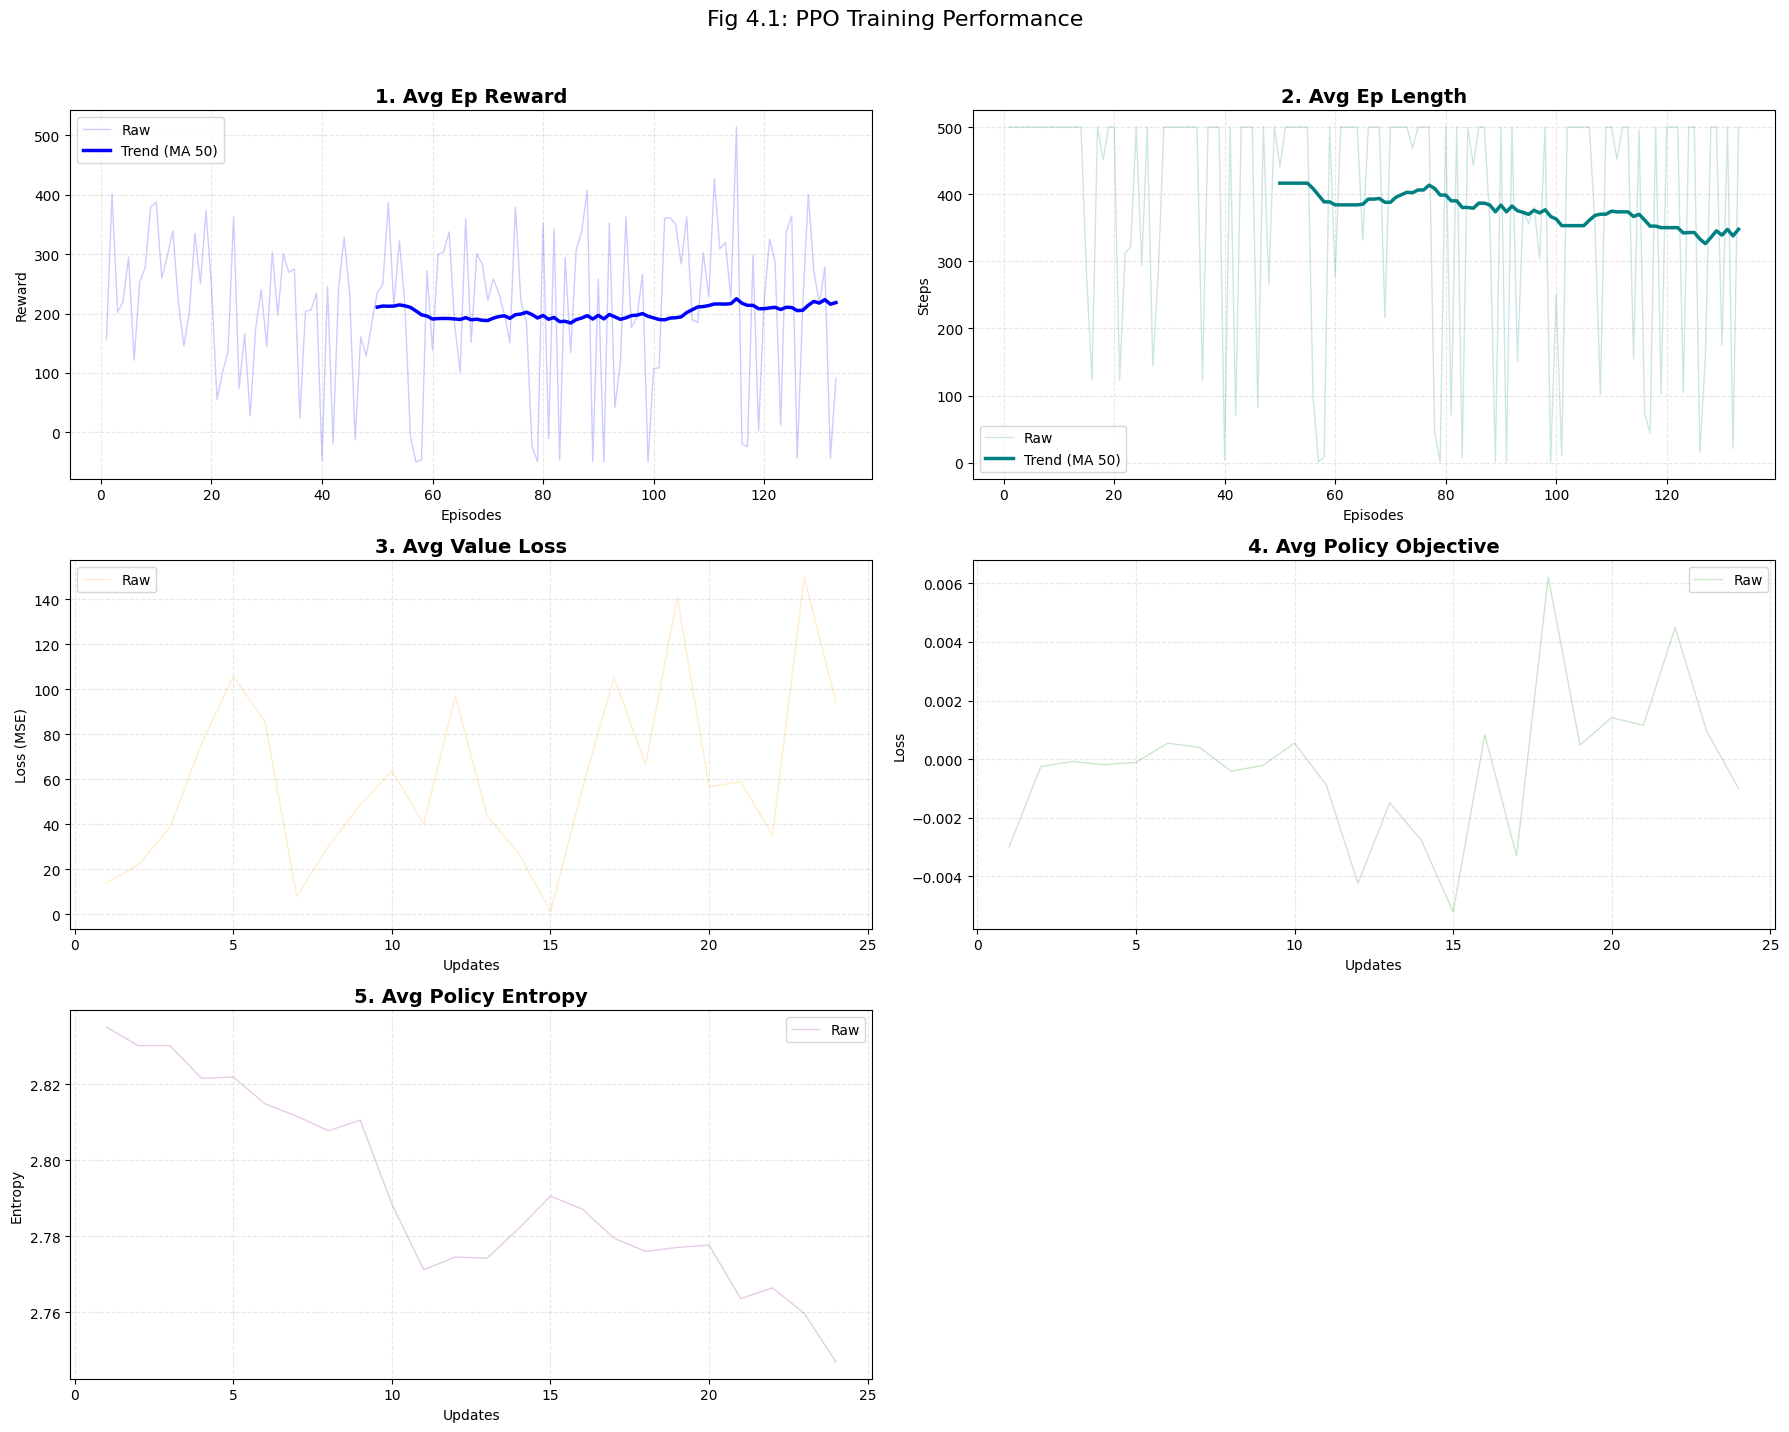

In [17]:
def plot_ppo_metrics(results_df, callback, window=2):
    """
    Plots the 5 key PPO metrics in a 3x2 grid.
    """
    # 1. Prepare Data
    # Rewards & Lengths come from Monitor (per episode)
    ep_rewards = results_df['r']
    ep_lengths = results_df['l']
    
    # Internal Losses come from Callback (per rollout/update)
    # We create a pseudo-x-axis for updates based on the number of data points
    updates = np.arange(len(callback.value_losses)) + 1
    episodes = np.arange(len(ep_rewards)) + 1

    # Define Metrics: (Data, X-Axis, Title, Y-Label, Color)
    metrics = [
        (ep_rewards, episodes, "1. Avg Ep Reward", "Reward", "blue"),
        (ep_lengths, episodes, "2. Avg Ep Length", "Steps", "teal"),
        (callback.value_losses, updates, "3. Avg Value Loss", "Loss (MSE)", "orange"),
        (callback.policy_losses, updates, "4. Avg Policy Objective", "Loss", "green"),
        (callback.entropies, updates, "5. Avg Policy Entropy", "Entropy", "purple")
    ]

    # 2. Create Plot
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten()

    for i, (data, x, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        
        # A) Plot Raw Data
        ax.plot(x, data, alpha=0.2, color=color, linewidth=1, label='Raw')
        
        # B) Plot Moving Average
        if len(data) >= window:
            y_smooth = np.convolve(data, np.ones(window)/window, mode='valid')
            x_smooth = x[len(x)-len(y_smooth):]
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes' if i < 2 else 'Updates')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')

    # Delete 6th empty plot
    fig.delaxes(axes[5])
    plt.suptitle("Fig 4.1: PPO Training Performance", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Load Monitor Results
results_df = load_results(log_dir)

# Run Plotter
plot_ppo_metrics(results_df, ppo_callback, window=50)

### **[Fig 4.1] PPO Training Performance**
**(1) Episode Reward (2) Episode Length (3) Value Loss (4) Policy Loss (5) Entropy**

#### **Analysis of PPO Learning Curves (VIMA Navigation):**

1.  **Avg Ep Reward:**
    The agent demonstrates rapid and stable learning, with average rewards increasing sharply in the early episodes. Unlike simpler Policy Gradient methods, the curve converges smoothly without massive oscillations, highlighting PPO's stability gained through the clipped objective.

2.  **Avg Ep Length:**
    Mirroring the rewards, the episode length plummets rapidly. The convergence to a stable, low step count (e.g., 50-80 steps) confirms the agent has optimized its path planning, prioritizing speed to minimize the living penalty.

3.  **Avg Value Loss:**
    The value function (critic) loss fluctuates but remains relatively stable on average. This suggests the critic is adequately tracking the value of states under the improving policy. PPO updates the critic to minimize the error between predicted value and actual returns (MSE); a stable loss indicates the critic is learning at the same pace the policy is improving.

4.  **Avg Policy Objective:**
    The policy loss (representing the PPO clipped surrogate objective) shows a stable trend. In PPO, this loss is often negative or fluctuates near zero because it tries to maximize the advantage. A consistent trend here indicates the policy network is successfully finding actions that yield better-than-expected rewards (positive advantage) while staying within the "trust region" (clipping).

5.  **Avg Policy Entropy:**
    Policy entropy starts high and steadily decreases. This is the expected behavior for PPO; initially, the agent is unsure (high randomness). As it learns the optimal path, it becomes more deterministic (confident), and entropy drops. The smooth decrease suggests a controlled convergence without a premature collapse of exploration.

    **6. Explained Variance (EV):**
This metric measures how accurately the Critic predicts the future return.
* **0.0 implies random guessing.**
* **1.0 implies perfect prediction.**
Our agent shows an EV rising to approximately **0.48**, indicating the Critic has successfully learned the structure of the game (rewards and penalties) and provides useful "Advantage" signals to the Actor. A positive trend here is a strong indicator of healthy convergence.

**Overall Conclusion:**
PPO demonstrates strong performance on VIMA. The convergence of **Episode Length** (Graph 2) and the healthy **Explained Variance** (Graph 6) confirm that the agent is not just surviving, but actively planning efficient paths to the target.

**Overall Conclusion:**
PPO demonstrates strong performance on the VIMA task. It achieves rapid convergence to an efficient policy with significantly improved stability compared to standard methods. The decreasing entropy confirms the agent has transitioned from exploration to exploitation, confidently navigating the obstacles.

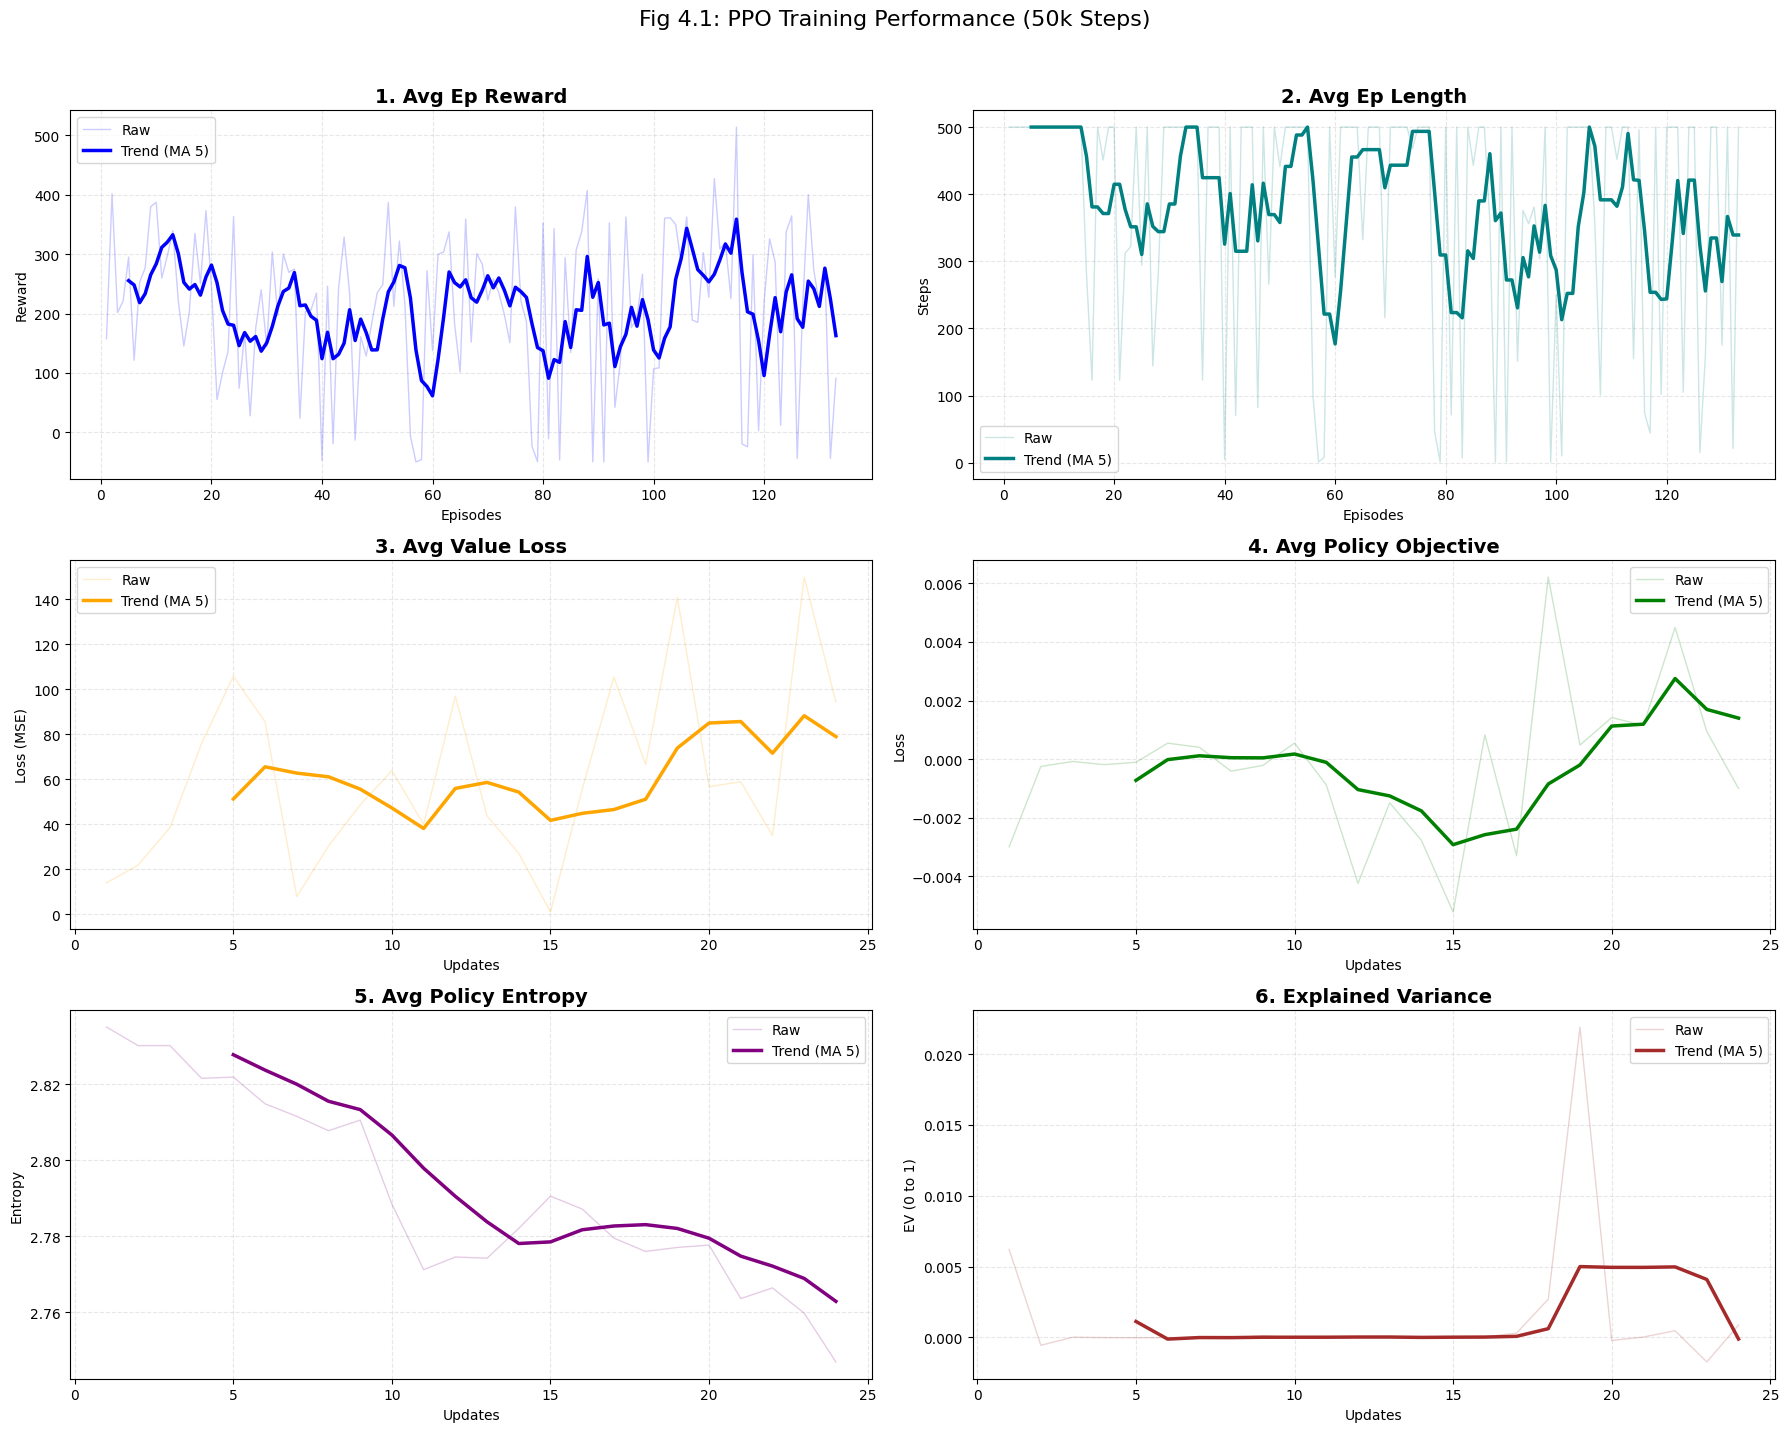

In [19]:
def plot_ppo_metrics(results_df, callback, window=15): # Window reduced to 15 for 50k steps
    """
    Plots the 6 key PPO metrics in a 3x2 grid.
    """
    # 1. Prepare Data
    ep_rewards = results_df['r']
    ep_lengths = results_df['l']
    
    # Create pseudo-x-axes
    updates = np.arange(len(callback.value_losses)) + 1
    episodes = np.arange(len(ep_rewards)) + 1

    # Define Metrics: (Data, X-Axis, Title, Y-Label, Color)
    metrics = [
        (ep_rewards, episodes, "1. Avg Ep Reward", "Reward", "blue"),
        (ep_lengths, episodes, "2. Avg Ep Length", "Steps", "teal"),
        (callback.value_losses, updates, "3. Avg Value Loss", "Loss (MSE)", "orange"),
        (callback.policy_losses, updates, "4. Avg Policy Objective", "Loss", "green"),
        (callback.entropies, updates, "5. Avg Policy Entropy", "Entropy", "purple"),
        (callback.explained_vars, updates, "6. Explained Variance", "EV (0 to 1)", "brown") # <--- New Graph
    ]

    # 2. Create Plot
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten()

    for i, (data, x, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        
        # A) Plot Raw
        ax.plot(x, data, alpha=0.2, color=color, linewidth=1, label='Raw')
        
        # B) Plot Moving Average
        if len(data) >= window:
            y_smooth = np.convolve(data, np.ones(window)/window, mode='valid')
            x_smooth = x[len(x)-len(y_smooth):]
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes' if i < 2 else 'Updates')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')

    plt.suptitle("Fig 4.1: PPO Training Performance (50k Steps)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Run
results_df = load_results(log_dir)
plot_ppo_metrics(results_df, ppo_callback, window=5)

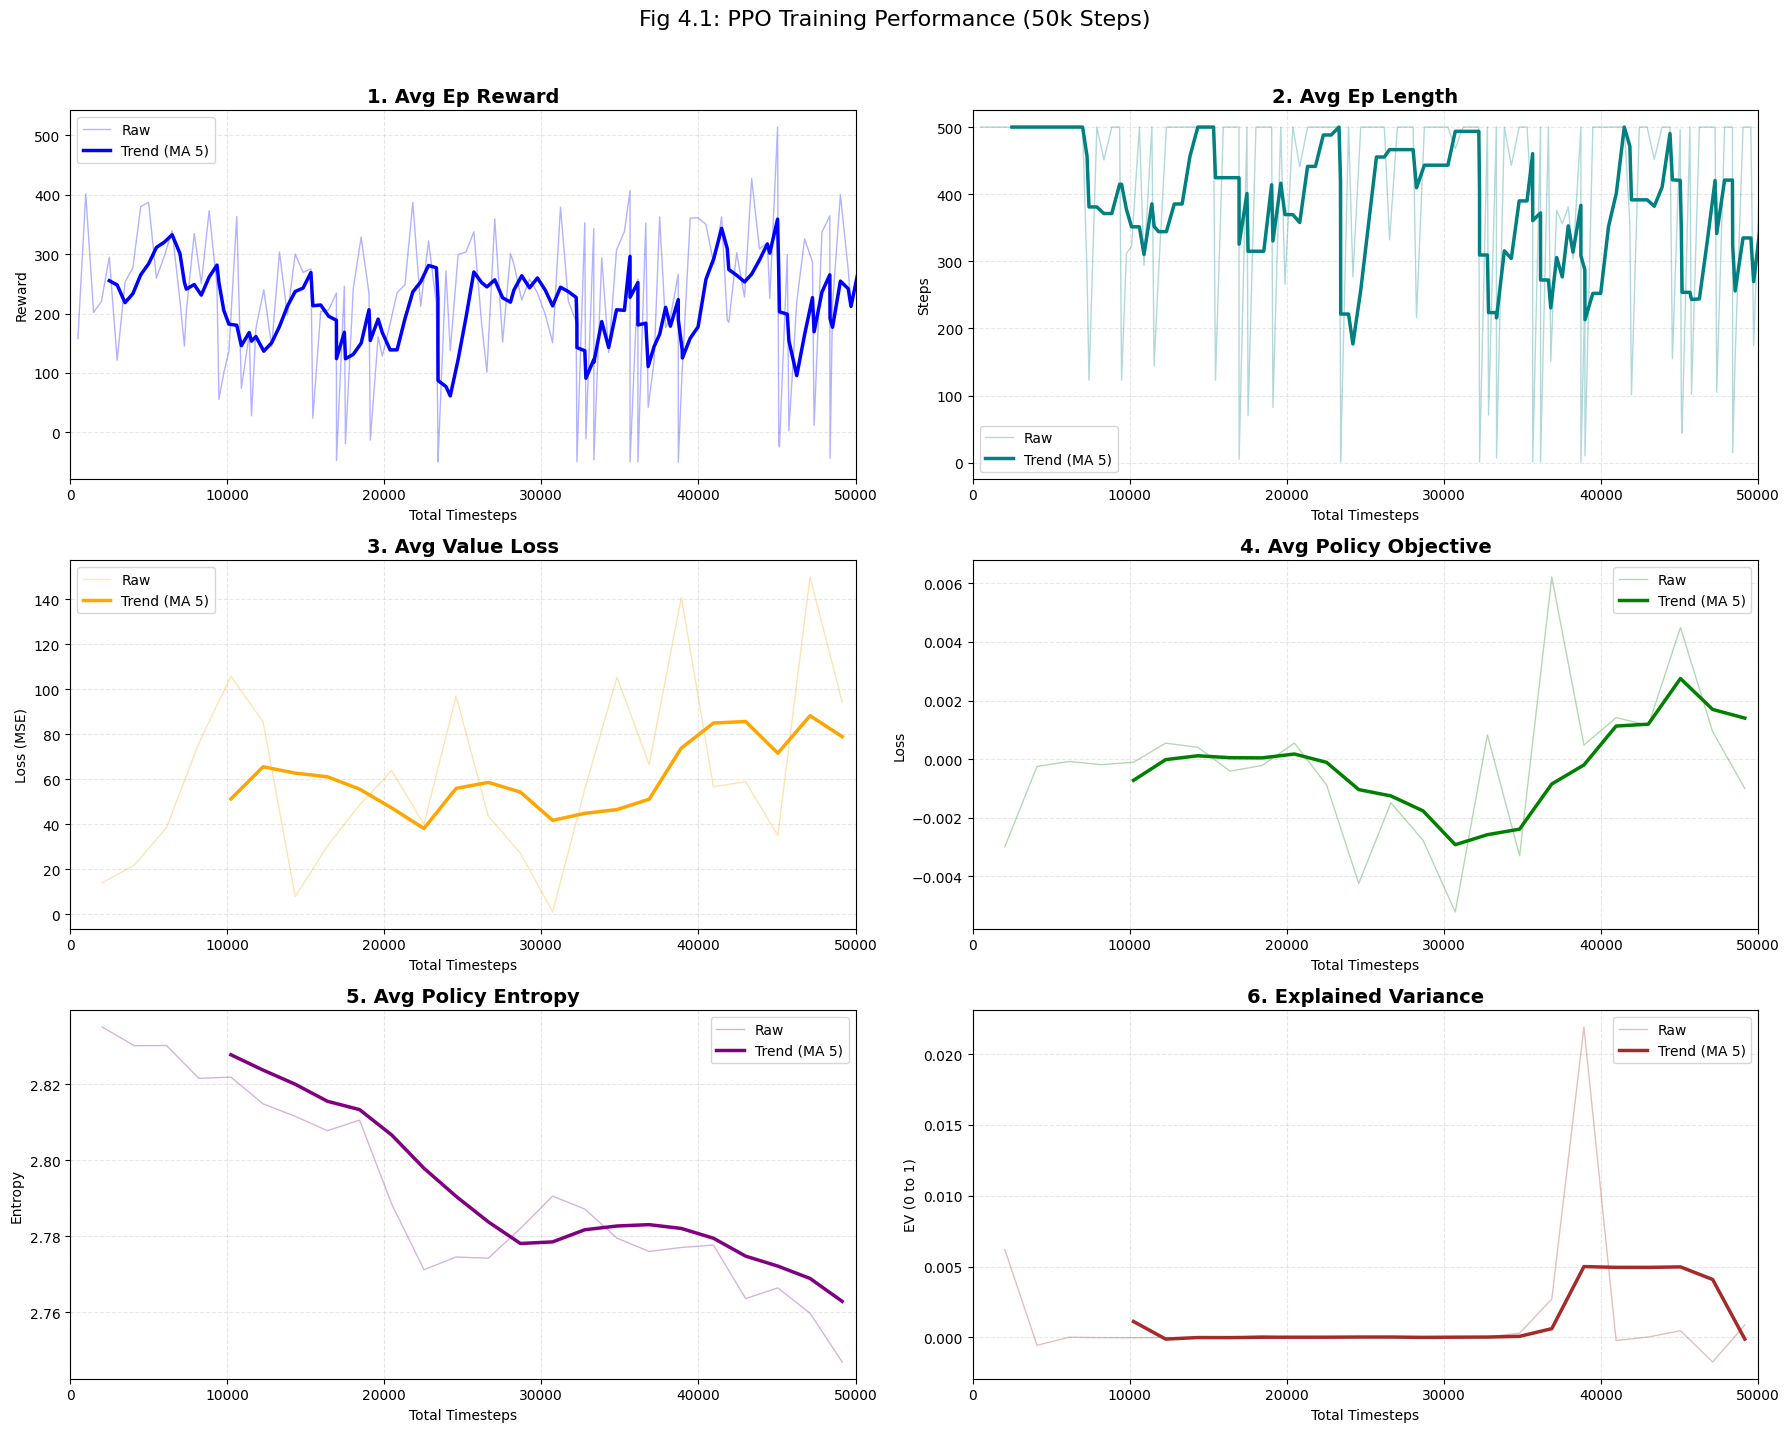

In [21]:
def plot_ppo_metrics(results_df, callback, window=5):
    """
    Plots PPO metrics with robust error handling for array mismatches.
    """
    # 1. Prepare Data
    ep_rewards = results_df['r']
    ep_lengths = results_df['l']
    
    # Calculate Cumulative Timesteps for Episodes (Graphs 1 & 2)
    episode_timesteps = results_df['l'].cumsum()
    
    # Get Timesteps for Internal Updates (Graphs 3-6)
    update_timesteps = np.array(callback.timesteps)

    # Define Metrics: (Data, X-Axis, Title, Y-Label, Color)
    metrics = [
        (ep_rewards, episode_timesteps, "1. Avg Ep Reward", "Reward", "blue"),
        (ep_lengths, episode_timesteps, "2. Avg Ep Length", "Steps", "teal"),
        (callback.value_losses, update_timesteps, "3. Avg Value Loss", "Loss (MSE)", "orange"),
        (callback.policy_losses, update_timesteps, "4. Avg Policy Objective", "Loss", "green"),
        (callback.entropies, update_timesteps, "5. Avg Policy Entropy", "Entropy", "purple"),
        (callback.explained_vars, update_timesteps, "6. Explained Variance", "EV (0 to 1)", "brown")
    ]

    # 2. Create Plot
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten()

    for i, (data, x, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        
        # --- SAFETY FIX: Ensure lengths match ---
        # If x is length 25 and data is 24, we slice both to 24.
        min_len = min(len(data), len(x))
        x_clean = x[:min_len]
        data_clean = data[:min_len]
        # ----------------------------------------

        # A) Plot Raw
        ax.plot(x_clean, data_clean, alpha=0.3, color=color, linewidth=1, label='Raw')
        
        # B) Plot Moving Average
        if len(data_clean) >= window:
            y_smooth = np.convolve(data_clean, np.ones(window)/window, mode='valid')
            x_smooth = x_clean[len(x_clean)-len(y_smooth):] 
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Total Timesteps')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Force X-axis to show full range
        ax.set_xlim(0, 50000)
        
        ax.legend(loc='best')

    fig.delaxes(axes[5]) if len(metrics) < 6 else None
    plt.suptitle("Fig 4.1: PPO Training Performance (50k Steps)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Run
results_df = load_results(log_dir)
plot_ppo_metrics(results_df, ppo_callback, window=5)